In [118]:
import pandas as pd
import numpy as np

import os
import warnings

from scipy.io import wavfile

from hmmlearn import hmm      

from python_speech_features import mfcc

from sklearn.externals import joblib

import feature_extraction

import matplotlib.pyplot as plt
mixed_dir = "../../mixed"

In [119]:
# load in mixed_metadata

metadata = pd.read_csv(mixed_dir + "/mixed_metadata.csv")

# create set of labels

labels_set = set(metadata['class'].value_counts().index)


In [120]:
# initialize feature extraction class

fe = feature_extraction.feature_extraction()


(399, 13)


Text(0.5, 1.05, 'MFCC')

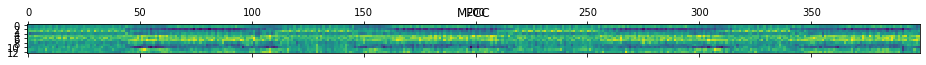

In [121]:
# test data intake

time_signal = fe.read("mixed_1_209864-5-0-0.wav")
mfccs = fe.return_mfcc(time_signal)
print(mfccs.shape)
plt.matshow(mfccs.T)
plt.title('MFCC')

In [122]:
### Define a class to train the HMM ###

# Parameters of `hmm.GaussianHMM()`:
# `n_components`: number of states of HMM
# `covariance_type`: type of covariance matrix for each state. 
# Each state is a random vector. 
# This parameter is a string defining the type of covariance matrix of this vector. Defaults to `"diagonal"`

class HMM_Model(object):
    
    def __init__(self, num_components=10, num_iter=30):
        
        self.n_components = num_components
        self.n_iter = num_iter
        
        # define the covariance type and the type of HMM:
        self.cov_type = 'diag'
        self.model_name = 'GaussianHMM'
        
        # initialize the variable in which we will store the models for each word:
        self.models = []
        
        # define the model using the specified parameters:
        self.model = hmm.GaussianHMM(n_components=self.n_components,
                                     covariance_type=self.cov_type,
                                     n_iter=self.n_iter, verbose=True)

    def train(self, training_data):
        
        """
        Defines a method to train the model
        'training_data' is a 2D numpy array where each row has the 
        length of number of mfcc coefficients
        """
        np.seterr(all='ignore')
        cur_model = self.model.fit(training_data)
        self.models.append(cur_model)

    
    def compute_score(self, input_data):
        
        """
        Define a method to compute log likelihood score for input features
        Returns: Log likelihood of sample input_data
        """
        return self.model.score(input_data)

In [123]:
def build_one_model(features_vector, num_states):
    
    """
    features_vector: nparray of features from Class above
    num_states: number of hidden states in HMM
    num_cep_coeff: number of MFCC features extracted from each time window
    """
    
    # initiate HMM model object
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore',category=DeprecationWarning)
        model = HMM_Model(num_components=num_states)

    # train HMM model, calculate likelihood of the sample by the trained model
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore',category=DeprecationWarning)
        model.train(X)
        model_score = model.compute_score(X)
        
    return model, model_score

In [124]:
def hmm_aic(LLik, n, k):
    
    """
    Takes in loglikelihood of trained HMM plus number of params
    Returns: Model AIC
    """
    return -2*LLik+2*(n*n+k*n-1)

In [125]:
def build_all_models(labels_set, metadata, num_states):
    
    """
    Given an input data folder with subfolders for each response label
    """
    
    # empty list for storing model results
    model_results = []
    validation_set = []
    
    for i in labels_set:

        # load in filenames relevant to a particular label
        label_file_names = list(metadata[metadata['class'] == i]['slice_file_name'])
        # reserve 20 percent for validation
        num_to_train = int(np.ceil(len(label_file_names) * .8))
        train = label_file_names[:num_to_train]
        validate = label_file_names[num_to_train:]
        # append the list of validation filenames and respective label to validation_set
        validation_set.append((validate, i))
        
        
        # create an empty array for appending features
        X = np.array([])
    
        print("loading in files for label: ", i)

        for j in range(len(train)):
        
            loaded = fe.read(label_file_names[j])
            mfcc_features = fe.return_mfcc(loaded)

            if len(X) == 0:
                
                X = mfcc_features
            
            else:
                
                X = np.append(X, mfcc_features, axis=0)
            
        print("training...")
        model = build_one_model(X, num_states=num_states)
        
        # add the model to the results list
        model_results.append((model, i))
        
        # Reset model variable
        model = None

    return model_results, validation_set


In [126]:
model_results, validation_set = build_all_models(labels_set, metadata, 10)

loading in files for label:  siren


training...


         1   -16269183.5801             +nan
         2   -15066710.5835    +1202472.9967
         3   -14940027.2191     +126683.3644
         4   -14861644.6292      +78382.5899
         5   -14806511.9149      +55132.7143
         6   -14771537.4974      +34974.4174
         7   -14746084.2496      +25453.2479
         8   -14734764.4951      +11319.7545
         9   -14725240.6411       +9523.8540
        10   -14719960.5616       +5280.0795
        11   -14716779.9686       +3180.5930
        12   -14714372.0179       +2407.9507
        13   -14712538.1011       +1833.9167
        14   -14711164.5114       +1373.5897
        15   -14710069.8260       +1094.6855
        16   -14709019.6148       +1050.2112
        17   -14708100.0127        +919.6021
        18   -14707462.3538        +637.6589
        19   -14706883.0126        +579.3411
        20   -14706151.5568        +731.4559
        21   -14705368.3913        +783.1655
        22   -14704862.0435        +506.3478
        23

loading in files for label:  jackhammer


training...


         1   -16292953.8125             +nan
         2   -15084643.8184    +1208309.9941
         3   -14931264.1489     +153379.6695
         4   -14871667.6034      +59596.5455
         5   -14848287.6648      +23379.9385
         6   -14831984.7212      +16302.9436
         7   -14817774.2583      +14210.4630
         8   -14801283.4002      +16490.8581
         9   -14784194.3833      +17089.0169
        10   -14772394.8610      +11799.5223
        11   -14759878.5958      +12516.2652
        12   -14751527.3949       +8351.2009
        13   -14747333.9845       +4193.4104
        14   -14744558.2607       +2775.7238
        15   -14742693.1826       +1865.0780
        16   -14740702.6719       +1990.5108
        17   -14738539.8880       +2162.7839
        18   -14736847.6230       +1692.2650
        19   -14735596.1862       +1251.4368
        20   -14734252.6590       +1343.5272
        21   -14732882.8707       +1369.7883
        22   -14731716.7472       +1166.1235
        23

loading in files for label:  air_conditioner


training...


         1   -16284803.8672             +nan
         2   -15064053.6279    +1220750.2393
         3   -14909129.9314     +154923.6965
         4   -14852663.7018      +56466.2296
         5   -14824361.9083      +28301.7935
         6   -14807217.3619      +17144.5464
         7   -14797133.0990      +10084.2629
         8   -14789397.2935       +7735.8055
         9   -14783479.4129       +5917.8806
        10   -14778263.0433       +5216.3695
        11   -14773526.5169       +4736.5265
        12   -14768949.2951       +4577.2217
        13   -14763529.8987       +5419.3965
        14   -14753269.2072      +10260.6915
        15   -14736914.3776      +16354.8296
        16   -14728614.9009       +8299.4767
        17   -14722274.0709       +6340.8299
        18   -14717243.6149       +5030.4561
        19   -14712498.0975       +4745.5173
        20   -14706393.7806       +6104.3169
        21   -14699923.6424       +6470.1382
        22   -14694337.5668       +5586.0756
        23

loading in files for label:  dog_bark


training...


         1   -16290538.5852             +nan
         2   -15071804.9846    +1218733.6005
         3   -14903423.8450     +168381.1396
         4   -14861822.6922      +41601.1529
         5   -14838715.3443      +23107.3478
         6   -14821391.0175      +17324.3268
         7   -14804837.7777      +16553.2398
         8   -14792898.0775      +11939.7002
         9   -14782054.3078      +10843.7698
        10   -14769116.4701      +12937.8377
        11   -14754936.8102      +14179.6599
        12   -14745654.3049       +9282.5054
        13   -14735633.2196      +10021.0852
        14   -14728309.7084       +7323.5112
        15   -14723279.4674       +5030.2410
        16   -14719551.4089       +3728.0585
        17   -14716344.6500       +3206.7589
        18   -14713146.0727       +3198.5773
        19   -14709916.3226       +3229.7501
        20   -14707135.5012       +2780.8214
        21   -14705320.6211       +1814.8800
        22   -14704747.5626        +573.0585
        23

loading in files for label:  engine_idling


training...


         1   -16292025.9650             +nan
         2   -15060705.3081    +1231320.6569
         3   -14918261.4767     +142443.8315
         4   -14882641.5794      +35619.8972
         5   -14863742.5550      +18899.0244
         6   -14835012.9093      +28729.6457
         7   -14810568.6385      +24444.2709
         8   -14782616.0239      +27952.6146
         9   -14771994.9611      +10621.0627
        10   -14766082.5957       +5912.3654
        11   -14762371.9443       +3710.6515
        12   -14759398.9966       +2972.9477
        13   -14755661.3166       +3737.6800
        14   -14741081.8545      +14579.4621
        15   -14733521.6595       +7560.1950
        16   -14731045.5690       +2476.0904
        17   -14727451.8303       +3593.7387
        18   -14724961.2792       +2490.5511
        19   -14721540.5481       +3420.7311
        20   -14718435.3390       +3105.2091
        21   -14717156.5345       +1278.8045
        22   -14716414.9697        +741.5648
        23

loading in files for label:  children_playing


training...


         1   -16323041.8781             +nan
         2   -14997602.3966    +1325439.4815
         3   -14887975.8217     +109626.5749
         4   -14847067.6686      +40908.1532
         5   -14824363.7341      +22703.9345
         6   -14806765.3123      +17598.4217
         7   -14789348.7704      +17416.5420
         8   -14768666.8527      +20681.9177
         9   -14753687.3626      +14979.4901
        10   -14744901.8301       +8785.5325
        11   -14739098.7447       +5803.0854
        12   -14735139.8800       +3958.8647
        13   -14731919.0333       +3220.8467
        14   -14728838.7499       +3080.2834
        15   -14726504.9495       +2333.8004
        16   -14724435.5008       +2069.4486
        17   -14722517.3282       +1918.1726
        18   -14719622.1647       +2895.1634
        19   -14718112.5107       +1509.6541
        20   -14717552.0667        +560.4439
        21   -14717162.6468        +389.4199
        22   -14716835.3657        +327.2812
        23

loading in files for label:  drilling


training...


         1   -16295003.8333             +nan
         2   -14994570.9810    +1300432.8522
         3   -14806624.8187     +187946.1623
         4   -14754414.2992      +52210.5195
         5   -14733557.3516      +20856.9476
         6   -14723829.2607       +9728.0909
         7   -14714787.9925       +9041.2682
         8   -14706474.8413       +8313.1512
         9   -14702366.3852       +4108.4561
        10   -14699039.1952       +3327.1900
        11   -14696198.9790       +2840.2162
        12   -14692850.0470       +3348.9320
        13   -14689199.7364       +3650.3106
        14   -14684175.9101       +5023.8263
        15   -14679480.5490       +4695.3611
        16   -14675906.3808       +3574.1681
        17   -14673911.8052       +1994.5756
        18   -14672851.0006       +1060.8045
        19   -14672062.9048        +788.0958
        20   -14671398.7607        +664.1441
        21   -14670792.7281        +606.0326
        22   -14670247.9083        +544.8198
        23

loading in files for label:  gun_shot


training...


         1   -16296073.1624             +nan
         2   -15038389.0680    +1257684.0944
         3   -14870523.6813     +167865.3867
         4   -14800682.4600      +69841.2212
         5   -14768379.1271      +32303.3329
         6   -14741595.7645      +26783.3626
         7   -14721837.7757      +19757.9888
         8   -14709312.6427      +12525.1330
         9   -14703197.4783       +6115.1644
        10   -14696219.9073       +6977.5710
        11   -14691025.9423       +5193.9649
        12   -14687899.4423       +3126.5000
        13   -14685491.4788       +2407.9635
        14   -14683672.2237       +1819.2551
        15   -14682016.7060       +1655.5177
        16   -14679695.7329       +2320.9731
        17   -14677603.7064       +2092.0265
        18   -14676400.8569       +1202.8495
        19   -14675628.5438        +772.3131
        20   -14675053.8717        +574.6720
        21   -14674624.1709        +429.7008
        22   -14674331.2777        +292.8932
        23

loading in files for label:  car_horn


training...


         1   -16288668.8361             +nan
         2   -15031819.1418    +1256849.6943
         3   -14864353.6303     +167465.5115
         4   -14793693.8851      +70659.7452
         5   -14761672.6866      +32021.1985
         6   -14751328.3489      +10344.3378
         7   -14743267.1723       +8061.1766
         8   -14736518.2529       +6748.9194
         9   -14730639.0324       +5879.2204
        10   -14726353.2488       +4285.7836
        11   -14723423.3773       +2929.8715
        12   -14720886.3906       +2536.9867
        13   -14718148.6112       +2737.7794
        14   -14715334.6013       +2814.0099
        15   -14713018.5187       +2316.0827
        16   -14711490.8724       +1527.6463
        17   -14710589.4533        +901.4191
        18   -14710075.0981        +514.3552
        19   -14709735.1510        +339.9472
        20   -14709456.0498        +279.1012
        21   -14709173.0613        +282.9885
        22   -14708766.9618        +406.0995
        23

loading in files for label:  street_music


training...


         1   -16292525.3802             +nan
         2   -14999659.5309    +1292865.8493
         3   -14846170.0571     +153489.4739
         4   -14781258.8520      +64911.2051
         5   -14750518.4675      +30740.3845
         6   -14736591.0524      +13927.4151
         7   -14725809.3295      +10781.7229
         8   -14716299.5361       +9509.7934
         9   -14708094.3013       +8205.2349
        10   -14701084.0376       +7010.2637
        11   -14695390.8383       +5693.1993
        12   -14690412.1754       +4978.6629
        13   -14686428.8421       +3983.3332
        14   -14684819.9343       +1608.9078
        15   -14683674.4487       +1145.4856
        16   -14682024.1474       +1650.3013
        17   -14679978.4187       +2045.7287
        18   -14678618.4157       +1360.0030
        19   -14677115.2965       +1503.1192
        20   -14675690.3987       +1424.8978
        21   -14675167.3431        +523.0556
        22   -14675087.5332         +79.8099
        23

In [127]:
model_results

[((<__main__.HMM_Model at 0x1c24989ad0>, -14702260.713874059), 'siren'),
 ((<__main__.HMM_Model at 0x1c2499be90>, -14712503.853600686), 'jackhammer'),
 ((<__main__.HMM_Model at 0x1c253bd7d0>, -14671898.652046138),
  'air_conditioner'),
 ((<__main__.HMM_Model at 0x1c24989490>, -14701337.82978613), 'dog_bark'),
 ((<__main__.HMM_Model at 0x1c2498f750>, -14708537.974123994),
  'engine_idling'),
 ((<__main__.HMM_Model at 0x1c253b8490>, -14714132.57254425),
  'children_playing'),
 ((<__main__.HMM_Model at 0x10c4030d0>, -14668656.750705127), 'drilling'),
 ((<__main__.HMM_Model at 0x1c22b768d0>, -14673803.299967524), 'gun_shot'),
 ((<__main__.HMM_Model at 0x1c25972990>, -14701690.055804493), 'car_horn'),
 ((<__main__.HMM_Model at 0x1c2498f0d0>, -14674981.68675521), 'street_music')]

In [128]:
# save to pkl

joblib.dump(model_results,'../../hmm_models/saved_models.pkl')

['../../hmm_models/saved_models.pkl']

In [129]:
# load from pkl

trained_models = set(joblib.load('../../hmm_models/saved_models.pkl'))

In [130]:
trained_models

{((<__main__.HMM_Model at 0x1c24989c90>, -14702260.713874059), 'siren'),
 ((<__main__.HMM_Model at 0x1c24d50090>, -14674981.68675521), 'street_music'),
 ((<__main__.HMM_Model at 0x1c24d52290>, -14671898.652046138),
  'air_conditioner'),
 ((<__main__.HMM_Model at 0x1c24d52490>, -14701337.82978613), 'dog_bark'),
 ((<__main__.HMM_Model at 0x1c24d52690>, -14708537.974123994),
  'engine_idling'),
 ((<__main__.HMM_Model at 0x1c24d52890>, -14714132.57254425),
  'children_playing'),
 ((<__main__.HMM_Model at 0x1c24d52a50>, -14668656.750705127), 'drilling'),
 ((<__main__.HMM_Model at 0x1c24d52c50>, -14673803.299967524), 'gun_shot'),
 ((<__main__.HMM_Model at 0x1c24d52e50>, -14701690.055804493), 'car_horn'),
 ((<__main__.HMM_Model at 0x1c2596e190>, -14712503.853600686), 'jackhammer')}

In [ ]:
def score_one_sample(trained_models, test_file_name):
    
    """
    trained_model: ModelHMM object with trained model
    test_file_path: path to wav file
    """
    # empty list to hold all of the scores
    scores = []
    
    # load in file from validation set and convert to mfcc features
    loaded = fe.read(test_file_name)
    mfcc_features = fe.return_mfcc(loaded)
    
    # iterator through each of the trained models
    for i in trained_models:
        
        # compute log likelihood score for using each of the trained models
        sample_score = trained_model[i].compute_score(features_mfcc)
        scores.append(sample_scores)
   
    return 

In [112]:
loaded = fe.read(test_file_name)
mfcc_features = fe.return_mfcc(loaded)

NameError: name 'test_file_name' is not defined